<a href="https://colab.research.google.com/github/srirambandi/GAN/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# when running in colab notebooks, first install library
!pip install import-ai
# upload respective dataset manually from examples directory of the library or download as below
!apt install subversion
!svn checkout https://github.com/srirambandi/ai/trunk/examples/MNIST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import ai
import numpy as np

In [4]:
z_dim = 100
gf_dim = 64
df_dim = 64

In [5]:
ai.manual_seed(2357)

In [6]:
def data_generator(m):
    train_dict = np.load('MNIST/train.npy', allow_pickle=True)
    test_dict = np.load('MNIST/test.npy', allow_pickle=True)
    data = np.concatenate([train_dict.item()['data'], test_dict.item()['data']])
    data = data.transpose(1, 2, 0)   # making data batch-last
    data = data.reshape(1, *data.shape) / 127.5 - 1.   # adding channel dimension and normalizing data
    epoch = 0
    
    while True:
        epoch += 1
        for batch in range(int(data.shape[-1] / m)):
            yield data[...,batch * m:(batch + 1) * m], epoch

In [7]:
class Generator(ai.Module):
    def __init__(self):
        self.g_fc = ai.Linear(z_dim, 8*gf_dim * 2 * 2)
        self.g_bn1 = ai.BatchNorm((8*gf_dim, 2, 2))
        self.g_deconv1 = ai.ConvTranspose2d(8*gf_dim, 4*gf_dim, kernel_size=5, stride=2, padding=2, a=1)
        self.g_bn2 = ai.BatchNorm((4*gf_dim, 4, 4))
        self.g_deconv2 = ai.ConvTranspose2d(4*gf_dim, 2*gf_dim, kernel_size=5, stride=2, padding=2, a=0)
        self.g_bn3 = ai.BatchNorm((2*gf_dim, 7, 7))
        self.g_deconv3 = ai.ConvTranspose2d(2*gf_dim, gf_dim, kernel_size=5, stride=2, padding=2, a=1)
        self.g_bn4 = ai.BatchNorm((gf_dim, 14, 14))
        self.g_deconv4 = ai.ConvTranspose2d(gf_dim, 1, kernel_size=5, stride=2, padding=2, a=1)
        
    def forward(self, z):
        o1 = ai.G.reshape(self.g_fc(z), (8*gf_dim, 2, 2))
        o2 = ai.G.relu(self.g_bn1(o1))
        o3 = ai.G.relu(self.g_bn2(self.g_deconv1(o2)))
        o4 = ai.G.relu(self.g_bn3(self.g_deconv2(o3)))
        o5 = ai.G.relu(self.g_bn4(self.g_deconv3(o4)))
        fake_image = ai.G.tanh(self.g_deconv4(o5))
        return fake_image

In [8]:
class Discriminator(ai.Module):
    def __init__(self):
        self.d_conv1 = ai.Conv2d(1, 64, kernel_size=5, stride=2, padding=2)
        self.d_conv2 = ai.Conv2d(64, 2*64, kernel_size=5, stride=2, padding=2)
        self.d_bn1 = ai.BatchNorm((2*64, 7, 7))
        self.d_conv3 = ai.Conv2d(2*64, 3*64, kernel_size=5, stride=2, padding=2)
        self.d_bn2 = ai.BatchNorm((3*64, 4, 4))
        self.d_conv4 = ai.Conv2d(3*64, 4*64, kernel_size=5, stride=2, padding=2)
        self.d_bn3 = ai.BatchNorm((4*64, 2, 2))
        self.d_fc = ai.Linear(1024, 1)
        
    def forward(self, image):
        o1 = ai.G.lrelu(self.d_conv1(image))
        o2 = ai.G.lrelu(self.d_bn1(self.d_conv2(o1)))
        o3 = ai.G.lrelu(self.d_bn2(self.d_conv3(o2)))
        o4 = ai.G.lrelu(self.d_bn3(self.d_conv4(o3)))
        o5 = self.d_fc(o4)
        return ai.G.sigmoid(o5)

In [9]:
generator = Generator()
discriminator = Discriminator()
print(generator)
print(discriminator)

Generator(
  g_fc: Linear(input_features=100, output_features=2048, bias=True)
  g_bn1: BatchNorm((512, 2, 2), axis=-1, momentum=0.9, bias=True)
  g_deconv1: ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), a=(1, 1), bias=True)
  g_bn2: BatchNorm((256, 4, 4), axis=-1, momentum=0.9, bias=True)
  g_deconv2: ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), a=(0, 0), bias=True)
  g_bn3: BatchNorm((128, 7, 7), axis=-1, momentum=0.9, bias=True)
  g_deconv3: ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), a=(1, 1), bias=True)
  g_bn4: BatchNorm((64, 14, 14), axis=-1, momentum=0.9, bias=True)
  g_deconv4: ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), a=(1, 1), bias=True)
)
Discriminator(
  d_conv1: Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=True)
  d_conv2: Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=True)
  d_bn1: BatchNorm((128

In [10]:
lr = 0.0002
beta1 = 0.5
L = ai.Loss(loss_fn='BCELoss')
g_optim = ai.Optimizer(generator.parameters(), optim_fn='Adam', lr=lr, beta1=beta1)
d_optim = ai.Optimizer(discriminator.parameters(), optim_fn='Adam', lr=lr, beta1=beta1)

In [11]:
it, epoch = 0, 0
m = 64   # batch size
n_discriminator = 1   # number of descriminator updates per generator update

# real images data generator
data = data_generator(m)

sample_z = np.random.uniform(-1, 1, (z_dim, m))
sampled_images = None

In [12]:
def sampler(sampled_images):
    ai.G.grad_mode = False

    # generate images like real data
    fake_images = generator.forward(sample_z).data
    fake_images = (fake_images + 1.) / 2.

    if sampled_images is not None:
        sampled_images = np.concatenate([sampled_images, fake_images], axis=-1)
    else:
        sampled_images = fake_images
    
    ai.G.grad_mode = True

    return sampled_images

In [ ]:
for it in range(10000):
    
    # freeze generator before optimizing descriminator
    for p in generator.parameters():
        p.eval_grad = False

    # training descriminator to identify real/fake data
    for _ in range(n_discriminator):

        real_images, epoch = data.__next__()
        real_labels = np.ones((1, m))
        if (real_images.shape[-1] != m):
            continue

        real_probs = discriminator.forward(real_images)
        d_loss_real = L.loss(real_probs, real_labels)

        z = np.random.randn(z_dim, m)
        fake_images = generator.forward(z)
        fake_labels =  np.zeros((1, m))

        fake_probs = discriminator.forward(fake_images)
        d_loss_fake = L.loss(fake_probs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.grad = np.zeros(d_loss.shape)

        d_loss.backward()
        d_optim.step()
        d_optim.zero_grad()

    # unfreeze generator
    for p in generator.parameters():
        p.eval_grad = True

    # training generator to fool descriminator with fake data
    z = np.random.uniform(-1, 1, (z_dim, m))
    fake_images = generator.forward(z)
    fake_labels =  np.ones((1, m))

    fake_probs = discriminator.forward(fake_images)
    g_loss = L.loss(fake_probs, fake_labels)

    g_loss.backward()
    g_optim.step()
    g_optim.zero_grad()
    d_optim.zero_grad()

    if it%10 == 0:
        print('Iter: {}, Epoch: {}, d_loss: {}, g_loss: {}'.format(it, epoch, d_loss.data[0, 0], g_loss.data[0, 0]))
    
    if it%100 == 0:
        sampled_images=sampler(sampled_images)
        np.save('/content/drive/My Drive/GAN/sampled_images.npy', sampled_images)
        generator.save('/content/drive/My Drive/GAN/Generator.npy')
        discriminator.save('/content/drive/My Drive/GAN/Discriminator.npy')

using Adam
using Adam
Iter: 0, Epoch: 1, d_loss: 1.428378585515031, g_loss: 0.8336541166575898
saving model...
Successfully saved model in /content/drive/My Drive/GAN/Generator.npy
saving model...
Successfully saved model in /content/drive/My Drive/GAN/Discriminator.npy
Iter: 10, Epoch: 1, d_loss: 1.2464641248149557, g_loss: 0.8139733210835326
Iter: 20, Epoch: 1, d_loss: 1.0581492969136852, g_loss: 0.9107881979418991
Iter: 30, Epoch: 1, d_loss: 0.7710517345858514, g_loss: 1.20319439990047
Iter: 40, Epoch: 1, d_loss: 0.6476865341483928, g_loss: 1.3762620906011678
Iter: 50, Epoch: 1, d_loss: 0.663641557856633, g_loss: 1.471282854761247
Iter: 60, Epoch: 1, d_loss: 0.4625329208521405, g_loss: 1.6279811622472184
Iter: 70, Epoch: 1, d_loss: 0.4724186928247277, g_loss: 1.6868939288423483
Iter: 80, Epoch: 1, d_loss: 0.5072327712712987, g_loss: 1.7874108563302473
Iter: 90, Epoch: 1, d_loss: 0.47721944660767046, g_loss: 1.5524198350903728
Iter: 100, Epoch: 1, d_loss: 0.42825131104309, g_loss: 1.

In [ ]:
def save_images(sampled_images):
    
    import imageio

    grids = []
    for i in range(int(sampled_images.shape[-1]/m)):
        grid = []
        batch = sampled_images[...,i*64:(i+1)*64]

        for r in range(8):
            row = np.squeeze(batch[...,r*8])

            for c in range(1, 8):
                row = np.concatenate([row, np.squeeze(batch[...,r*8 + c])], axis=1)

            grid.append(row)

        grid = np.concatenate(grid, axis=0)
        grids.append(grid)

    imageio.mimsave('/content/drive/My Drive/GAN/gan.gif', grids)

sampled_images = np.load('/content/drive/My Drive/GAN/sampled_images.npy')
save_images(sampled_images)

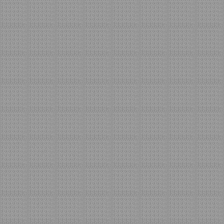

In [16]:
from IPython.display import Image

with open('/content/drive/My Drive/GAN/gan.gif','rb') as f:
    display(Image(data=f.read(), format='png'))